In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
%matplotlib inline

In [96]:
hitters_df = pd.read_csv('data/Hitters.csv')
hitters_df.dropna(inplace=True)
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [97]:
#对非数字的特征编码
hitters_df['League'] = pd.factorize(hitters_df['League'])[0]
hitters_df['Division'] = pd.factorize(hitters_df['Division'])[0]
hitters_df['NewLeague'] = pd.factorize(hitters_df['NewLeague'])[0]
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [49]:
hitters_df.shape

(263, 20)

In [31]:
collist = [col for col in hitters_df.columns if col != 'Salary']
X = hitters_df[collist]
y = hitters_df['Salary']
reg = LinearRegression()
reg.fit(X,y)
ypred = reg.predict(X)
np.sqrt(mean_squared_error(ypred,y))

303.34447253531613

###Best Subset Regression

range(1, 19)


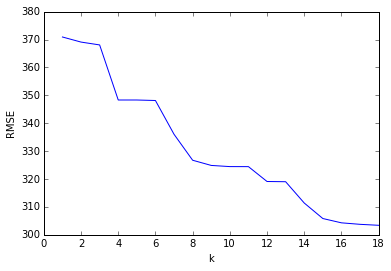

In [7]:
mses = []
nfeatures = range(1,len(collist))
print(nfeatures)
for nfeature in nfeatures:
    #特征选择，回归问题利用f-regression函数，返回K个最高的特征
    X_new = SelectKBest(f_regression,k=nfeature).fit(X,y)
    #X_new表示经过选择后的训练集
    selected = X_new.get_support()
    feats = [col for (col,sel) in zip(collist,selected) if sel]
    reg = LinearRegression()
    X_r = hitters_df[feats]
    reg.fit(X_r,y)
    ypred = reg.predict(X_r)
    mses.append(np.sqrt(mean_squared_error(ypred,y)))
plt.plot(nfeatures,mses)
plt.xlabel('k')
plt.ylabel('RMSE')

###Model Selection by Cross-Validation

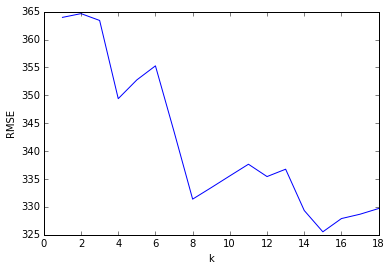

In [46]:
cv_errors = []
kfold = KFold(len(hitters_df),n_folds=10)
for nfeature in nfeatures:
    X_new = SelectKBest(f_regression, k=nfeature).fit(X,y)
    selected = X_new.get_support()
    feats = [col for (col,sel) in zip(collist,selected) if sel]
    X_r = hitters_df[feats].values
    y = hitters_df['Salary'].values
    rmses = []
    for train , test in kfold:
        Xtrain,ytrain,Xtest,ytest = X_r[train],y[train],X_r[test],y[test]
        ret = LinearRegression()
        reg.fit(Xtrain,ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ypred, ytest)))
    cv_errors.append(np.mean(rmses))
plt.plot(nfeatures,cv_errors)
plt.xlabel('k')
plt.ylabel('RMSE')

In [9]:
def cross_validate(X,y,nfolds,reg_name):
    rmses = []
    kfold = KFold(X.shape[0],n_folds=nfolds)
    for train,test in kfold:
        Xtrain,ytrain,Xtest,ytest = X[train],y[train],X[test],y[test]
        reg = None
        if reg_name == 'ridge':
            reg = Ridge()
        elif reg_name == 'Lasso':
            reg = Lasso()
        else:
            reg = LinearRegression()
        reg.fit(Xtrain,ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest,ypred)))
    return np.mean(rmses)

collist = [col for col in hitters_df.columns if col != 'Salary']
X = hitters_df[collist].values
y = hitters_df['Salary'].values
rmse_baseline = cross_validate(X,y,10,'baseline')
rmse_ridge = cross_validate(X,y,10,'ridge')
rmse_lasso = cross_validate(X,y,10,'lasso')
(rmse_baseline,rmse_ridge,rmse_lasso)

(331.00425667935792, 330.72572506106638, 331.00425667935792)

C:\Program Files (x86)\WinPython-64bit-3.4.3.4\python-3.4.3.amd64\lib\site-packages\sklearn\linear_model\coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


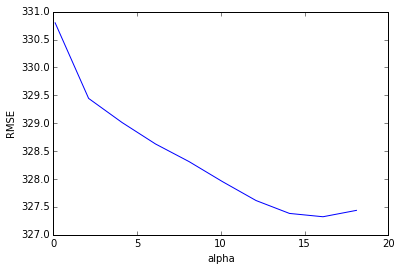

In [24]:
## find alpha
new_cv_errors = []
alphas = [0.1 * alpha for alpha in range(1,200,20)]
kfold = KFold(X.shape[0],n_folds =10)
for alpha in alphas:
    rmses = []
    for train ,test in kfold:
        Xtrain,ytrain,Xtest,ytest = X[train],y[train],X[test],y[test]
        reg = Lasso(alpha = alpha)
        reg.fit(Xtrain,ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest,ypred)))
    new_cv_errors.append(np.mean(rmses))
plt.plot(alphas,new_cv_errors)
plt.xlabel('alpha')
plt.ylabel('RMSE')

In [25]:
#sklearn内置的cross_validate
from sklearn import linear_model

In [28]:
clf = linear_model.LassoCV(alphas=alphas)
clf.fit(X,y)

C:\Program Files (x86)\WinPython-64bit-3.4.3.4\python-3.4.3.amd64\lib\site-packages\sklearn\linear_model\coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
C:\Program Files (x86)\WinPython-64bit-3.4.3.4\python-3.4.3.amd64\lib\site-packages\sklearn\linear_model\coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=[0.1, 2.1, 4.1000000000000005, 6.1000000000000005, 8.1, 10.100000000000001, 12.100000000000001, 14.100000000000001, 16.1, 18.1],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [29]:
clf.alpha_

18.100000000000001

##Principal Components Regression

In [84]:
collist = [col for col in hitters_df.columns if col != 'Salary']
X = hitters_df[collist].values
y = hitters_df['Salary'].values

In [59]:
X.shape,y.shape

((263, 19), (263,))

In [52]:
from sklearn.preprocessing import normalize

In [53]:
#normliztion,注意X的类型
X_norm = normalize(X.astype(np.float32),axis=1,norm='l2')

In [54]:
#step1:进行主成分分析
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components= 5)
#对X_norm进行分解
pca.fit(X_norm)
X_pca = pca.transform(X_norm)
X_pca

array([[  8.56573209e-02,   2.20261682e-02,   1.90349610e-03, ...,
          1.16929049e-02,   2.71928008e-03,   0.00000000e+00],
       [  2.37035573e-01,   6.43311590e-02,   8.90739076e-03, ...,
          4.05781157e-02,   6.92797080e-03,   4.94855049e-04],
       [  8.26242194e-02,   2.34879330e-02,   3.33162164e-03, ...,
          1.83239195e-03,   4.99743270e-04,   0.00000000e+00],
       ..., 
       [  2.56903142e-01,   6.81469366e-02,   1.62254611e-03, ...,
          6.11159019e-02,   3.78594082e-03,   5.40848705e-04],
       [  1.55441552e-01,   3.90638448e-02,   2.44149030e-03, ...,
          3.55372503e-02,   3.25532048e-03,   2.71276716e-04],
       [  1.20098226e-01,   3.23560983e-02,   1.71296997e-03, ...,
          7.61319941e-04,   5.70989971e-04,   1.90329985e-04]], dtype=float32)

In [90]:
#step2:linear regression
reg = LinearRegression()
reg.fit(X_pca,y)
ypred = reg.predict(X_pca)
np.mean(np.sqrt(mean_squared_error(ypred,y)))

290.62835369435248

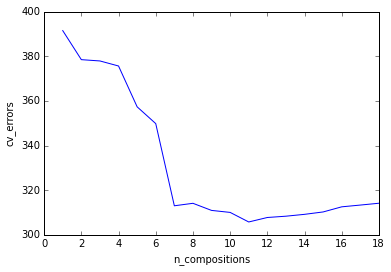

In [88]:
###交叉检验测试分解成成分
cv_errors = []
n_components= range(1,19)
k_flod = KFold(X.shape[0],n_folds=10)
for n_component in n_components:
    pca = PCA(n_components=n_component)
    X_pca = pca.fit_transform(X_norm)
    rmses = []
    for train,test in k_flod:
        Xtrain,ytrain,Xtest,ytest = X_pca[train],y[train],X_pca[test],y[test]
        reg = LinearRegression().fit(Xtrain,ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ypred,ytest)))
    cv_errors.append(np.mean(rmses))
    
plt.plot(n_components,cv_errors)
plt.xlabel('n_compositions')
plt.ylabel('cv_errors')

##Partial Least Squares

In [106]:
from sklearn.cross_decomposition import PLSRegression

In [125]:
collist = [col for col in hitters_df.columns if col != 'Salary']
X = hitters_df[collist].values
y = hitters_df['Salary'].values

In [126]:
#normliztion,注意X的类型
X_norm = normalize(X.astype(np.float64),axis=1,norm='l2')

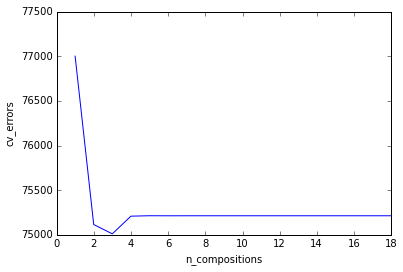

In [128]:
###交叉检验测试分解成成分
cv_errors = []
n_components= range(1,19)
k_flod = KFold(X.shape[0],n_folds=10)
for n_component in n_components:
    pls1 = PLSRegression(n_components=n_component)
    rmses = []
    for train,test in k_flod:
        Xtrain,ytrain,Xtest,ytest = X_pca[train],y[train],X_pca[test],y[test]
        pls1.fit(Xtrain,ytrain)
        ypred = pls1.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ypred,ytest)))
    cv_errors.append(np.mean(rmses))
    
plt.plot(n_components,cv_errors)
plt.xlabel('n_compositions')
plt.ylabel('cv_errors')

array([[315,  81,   7, ...,  43,  10,   0],
       [479, 130,  18, ...,  82,  14,   1],
       [496, 141,  20, ...,  11,   3,   0],
       ..., 
       [475, 126,   3, ..., 113,   7,   1],
       [573, 144,   9, ..., 131,  12,   1],
       [631, 170,   9, ...,   4,   3,   1]], dtype=int64)